In [1]:
import asyncio
import collections
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from docx import Document
from rpy2.robjects import r, pandas2ri
import re
import sys
sys.path.append("../")

import importlib
import llm_models
importlib.reload(llm_models)

from llm_models.utils import setup_transmission_chain
from llm_models.tasks import TaskFactory
from llm_models.enums import TaskType, AzureOpenAIModelType
from llm_models.node import Node
from llm_models.openai_model import AzureOpenAIModel

study_data = Path("../llm_models/study-data/").resolve()


LINESTYLES = ["-", ":", "--"]
EXP = ['GPT/HumanEval', 'GPT/GPTEval', 'GPT/GPTEval(New)']

MUKI = "Muki"
TAKATORO = "TakaToro"

MUKI_CODING = "coding/study5_Muki.xlsx"
TAKATORO_CODING =  "coding/study5_TakaToro.xlsx"

MUKI_OUTPUT = "output/Multiple biases - Muki.docx"
TAKATORO_OUTPUT =  "output/Multiple biases - Taka and Toro.docx"

STUDIES = {
    'coding': [MUKI_CODING, TAKATORO_CODING],
    'output': [MUKI_OUTPUT, TAKATORO_OUTPUT]
}
STUDIES['cleaned_coding_data']= {}

%load_ext autoreload
%autoreload 2

## Data Cleaning

In [2]:
data = pd.read_excel(str(study_data / MUKI_CODING))
data = data.rename(columns={
    'Unnamed: 0': "Number",
    'Unnamed: 1': "Text part", 
    'Unnamed: 2': "Type_1",
    'Unnamed: 3': "Type_2",
    'Unnamed: 4': "Type_3",
    'Chain Step 1': "sim:0 gen:0",
    'Unnamed: 6': "sim:1 gen:0",
    'Unnamed: 7': "sim:2 gen:0",
    'Unnamed: 8': "sim:3 gen:0",
    'Unnamed: 9': "sim:4 gen:0",
    'Chain Step 2': "sim:0 gen:1",
    'Unnamed: 12': "sim:1 gen:1",
    'Unnamed: 13': "sim:2 gen:1",
    'Unnamed: 14': "sim:3 gen:1",
    'Unnamed: 15': "sim:4 gen:1",
    'Chain Step 3': "sim:0 gen:2",
    'Unnamed: 18': "sim:1 gen:2",
    'Unnamed: 19': "sim:2 gen:2",
    'Unnamed: 20': "sim:3 gen:2",
    'Unnamed: 21': "sim:4 gen:2"
}
)

data = data.drop(columns=['Unnamed: 10', 'Unnamed: 16'])
data = data.iloc[1:]
data = data.fillna(0)

# normalize all counterintutive (CI) tags
for col in ['Type_1', 'Type_2', 'Type_3']:
    for ci_type in ['CI_B', 'CI_P', 'CI_M']:
        reg = f'{ci_type}\d+'
        data[col] = data[col].apply(lambda x: re.sub(reg, ci_type, x) if x != 0 else x)

STUDIES['cleaned_coding_data'][MUKI] = data
data

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_6351/191125971.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(0)


,Number,Text part,Type_1,Type_2,Type_3,sim:0 gen:0,sim:1 gen:0,sim:2 gen:0,sim:3 gen:0,sim:4 gen:0,sim:0 gen:1,sim:1 gen:1,sim:2 gen:1,sim:3 gen:1,sim:4 gen:1,sim:0 gen:2,sim:1 gen:2,sim:2 gen:2,sim:3 gen:2,sim:4 gen:2
1,24,"HUNT, PEOPLE, MATA, PATA",Social_Gossip,Survival,Emo_Neg,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2,76,"UNTIL, 73, 74, 75",Rational,CI_B,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,94,"BECOME GREAT RIVER, TEARS",Rational,CI_B,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,96,"FROM, HAIRS, MATA, HEAD, 95",Rational,CI_B,0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
5,78,"DART AWAY, SPARK",Emo_Neg,CI_M,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,253,"WAIT, US, 251, 252",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,257,"SLEEP, 254",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,258,"DEEPLY, SLEEP",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264,259,"GROW, 254",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# takatoro
data = pd.read_excel(str(study_data / TAKATORO_CODING))
data = data.rename(columns={
    'Unnamed: 0': "Number",
    'Unnamed: 1': "Text part", 
    'Unnamed: 2': "Type_1",
    'Unnamed: 3': "Type_2",
    'Chain Step 1': "sim:0 gen:0",
    'Unnamed: 5': "sim:1 gen:0",
    'Unnamed: 6': "sim:2 gen:0",
    'Unnamed: 7': "sim:3 gen:0",
    'Unnamed: 8': "sim:4 gen:0",
    'Chain Step 2': "sim:0 gen:1",
    'Unnamed: 11': "sim:1 gen:1",
    'Unnamed: 12': "sim:2 gen:1",
    'Unnamed: 13': "sim:3 gen:1",
    'Unnamed: 14': "sim:4 gen:1",
    'Chain Step 3': "sim:0 gen:2",
    'Unnamed: 17': "sim:1 gen:2",
    'Unnamed: 18': "sim:2 gen:2",
    'Unnamed: 19': "sim:3 gen:2",
    'Unnamed: 20': "sim:4 gen:2"
}
)

data = data.drop(columns=['Unnamed: 9', 'Unnamed: 15'])
data = data.iloc[1:]
data = data.fillna(0)

data['Type_3'] = 0

# normalize all counterintutive (CI) tags
for col in ['Type_1', 'Type_2', 'Type_3']:
    for ci_type in ['CI_B', 'CI_P', 'CI_M']:
        reg = f'{ci_type}\d+'
        data[col] = data[col].apply(lambda x: re.sub(reg, ci_type, x) if x != 0 else x)

data = data[STUDIES['cleaned_coding_data'][MUKI].columns]
STUDIES['cleaned_coding_data'][TAKATORO] = data
data

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_6351/2073900246.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(0)


,Number,Text part,Type_1,Type_2,Type_3,sim:0 gen:0,sim:1 gen:0,sim:2 gen:0,sim:3 gen:0,sim:4 gen:0,sim:0 gen:1,sim:1 gen:1,sim:2 gen:1,sim:3 gen:1,sim:4 gen:1,sim:0 gen:2,sim:1 gen:2,sim:2 gen:2,sim:3 gen:2,sim:4 gen:2
1,15,"WHERE, 12, 14",Rational,CI_B,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31,"CACKLE, PUNA",Social_Basic,CI_M,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53,"CACKLE, PUNA",Social_Basic,CI_M,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,91,"DEMAND, ANTS",Social_Basic,CI_M,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,177,"SPEAK, KAWA",Social_Basic,CI_M,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,264,"TRADE, WINDS",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,267,"WHICH, 262, 265, 266",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271,268,"REMEMBER, US, 267",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272,270,"HAVE, US, FORTUNE",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
content_type = set()
for data in STUDIES['cleaned_coding_data'].values():
    x = data[['Type_1', 'Type_2', 'Type_3']].stack().unique().tolist()
    x.remove(0)
    content_type.update(x)

content_type = [str(x) for x in content_type]


RETENTION_CONTENT = "CI_Social_Negative"
OTHER_CONTENT = "Others"
RETENTION_CONTENT_TYPES = ['Social_Basic', 'Social_Gossip', 'Emo_Neg', 'CI_B', 'Negative']
OTHER_CONTENT_TYPES = [x for x in content_type if x not in RETENTION_CONTENT_TYPES]

# Content Type and their tags
# social-basic: Social_Basic
# social-gossip: Social_Gossip
# survival: Survival
# emotional-positive: Emo_Posi
# emotional-negative: Emo_Neg
# moral: Moral
# rational: Rational
# counterintuitive-biological: CI_B1, CI_B2, ...
# counterintuitive-physical: CI_P1, CI_P2, ...
# counterintuitive-mental: CI_M1, CI_M2, ...


# Hypothesis
# RETENTION_CONTENT_TYPES = Social_Basic, Social_Gossip, Emo_Neg, CI_Bx
# OTHER_CONTENT_TYPES = # all others

lmer_levels = "c(" + f'"{OTHER_CONTENT}", "{RETENTION_CONTENT}"' + ")"

LABEL_COLORS = [(RETENTION_CONTENT, 'orange'), (OTHER_CONTENT, 'gray')]

In [5]:
print(OTHER_CONTENT_TYPES)
print(lmer_levels)
print(LABEL_COLORS)

['Survival', 'CI_M', 'Rational', 'CI_P', 'Positive', 'Moral', 'Emo_Posi']
c("Others", "CI_Social_Negative")
[('CI_Social_Negative', 'orange'), ('Others', 'gray')]


### Helper functions

In [35]:
def convert_annotations_to_proportions(results):
    """Converts annotations to final data for lmer and plotting.
    IMPORTANT: ADJUST ACCORDING TO THE TASK.
    """
    data = []
    for col in results.columns:
        if col == "original":
            continue
    
        chain_id = int(col[4])
        step_id = int(col[-1])
    
        retent_prop = 1. * results.loc[RETENTION_CONTENT, col] / results.loc[RETENTION_CONTENT, 'original']
        other_prop = 1. * results.loc[OTHER_CONTENT, col] / results.loc[OTHER_CONTENT, 'original']
    
        x = (chain_id, step_id, retent_prop, RETENTION_CONTENT)
        data.append(x)
    
        x = (chain_id, step_id, other_prop, OTHER_CONTENT)
        data.append(x)
    
    data = pd.DataFrame(data, columns=["chain_id", "chain_step", "proportion", "content"])
    return data


def lmer(data, str_levels=None):
    """Performs LMER."""
    pandas2ri.activate() 

    # Load the lme4 library in R
    r('library(lme4)')
    r('library(lmerTest)')
    
    # Convert the DataFrame to an R data.frame
    rdf = pandas2ri.py2rpy(data)
    
    # Fit the model in R
    r.assign('rdf', rdf)
    if str_levels is None:
        levels = data['content'].unique()
        str_levels = "c(" + ",".join([f'"{cat}"' for cat in levels]) +  ")"

    r(f'rdf$content <- factor(rdf$content, levels = {str_levels})')
    model = r('lmer(proportion ~ content + (1|chain_step) + (1|chain_id), data=rdf)')
    
    # Print the summary
    print(r('summary')(model))


def convert_summaries_to_annotations(all_sims):
    """Converts summaries to annotations in the form present in the anlaysis folder."""
    # prepare data
    results_exp = {}  
    results_exp['original'] = collections.Counter()

    type_cols = ['Type_1', 'Type_2', 'Type_3']
    for study in all_sims:
        exp_analysis = STUDIES['cleaned_coding_data'][study]
        analysis = exp_analysis[['Text part'] + type_cols]
        simulations = all_sims[study]
        for sim_id, all_nodes in enumerate(simulations):
            for generation in all_nodes:
                for node in generation:
                    col = f"sim:{sim_id} gen:{node.id[0]}"
                    analysis.loc[:, col] = 0
                    for x in node.evaluation.split("\n"):
                        if not x:
                            continue
                        try:
                            row = int(x)
                        except:
                            row = int(x.split("\t")[0])
                        analysis.loc[row, col] = 1

        
        sim_cols = analysis.columns[5:]
        for col in sim_cols:
            if col not in results_exp:
                results_exp[col] = collections.Counter()
                
            for type_col in ['Type_1', 'Type_2', 'Type_3']:
                codes = analysis[analysis[col] == 1][type_col]
                results_exp[col] += collections.Counter(codes)
        
        for type_col in ['Type_1', 'Type_2', 'Type_3']:
            results_exp['original'] += collections.Counter(analysis[type_col])
   
    # results_exp['original'] = collections.Counter(exp_analysis['Type'])
    results_exp = pd.DataFrame(results_exp)
    results_exp = results_exp.fillna(0)
    results_exp = results_exp.drop(0) # remove the index 0 (untagged content)
    
    results_exp.loc[RETENTION_CONTENT] = results_exp.loc[RETENTION_CONTENT_TYPES].sum()
    results_exp.loc[OTHER_CONTENT] = results_exp.loc[OTHER_CONTENT_TYPES].sum()

    return results_exp


def plot(ALL_DATA, ax):
    """Plots all the data. """
    for idx, key in enumerate(EXP):
        if key not in ALL_DATA:
            continue
        plot_data = ALL_DATA[key]
        max_gen = int(plot_data["chain_step"].max())
        for label, color in LABEL_COLORS:
            means, stds = [], []
            for gen in range(max_gen+1):
                filter = (plot_data["chain_step"] == gen) & (plot_data["content"] == label)
                means.append(plot_data.loc[filter, "proportion"].mean())
                stds.append(plot_data.loc[filter, "proportion"].std() / np.sqrt(sum(filter)))
            use_label = label if idx == 0 else None 
            alpha = 0.25 if idx > 0 else 0.75 # emphasize the first one
            ax.plot(range(max_gen + 1), means, color=color, alpha=alpha, label=use_label)
            ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=alpha, capsize=2, linewidth=1, linestyle=LINESTYLES[idx])
            ax.scatter(range(max_gen + 1), means, color=color)

    return ax

## Authors' Results

In [8]:
results_exp = {}  
results_exp['original'] = collections.Counter()
for study in [MUKI, TAKATORO]:
    exp_analysis = STUDIES['cleaned_coding_data'][study]
    sim_cols = exp_analysis.columns[5:]
    for col in sim_cols:
        if col not in results_exp:
            results_exp[col] = collections.Counter()
            
        for type_col in ['Type_1', 'Type_2', 'Type_3']:
            codes = exp_analysis[exp_analysis[col] == 1][type_col]
            results_exp[col] += collections.Counter(codes)
    
    for type_col in ['Type_1', 'Type_2', 'Type_3']:
        results_exp['original'] += collections.Counter(exp_analysis[type_col])

results_exp = pd.DataFrame(results_exp)
results_exp = results_exp.fillna(0)
results_exp = results_exp.drop(0) # remove the index 0 (untagged content)
    
results_exp.loc[RETENTION_CONTENT] = results_exp.loc[RETENTION_CONTENT_TYPES].sum()
results_exp.loc[OTHER_CONTENT] = results_exp.loc[OTHER_CONTENT_TYPES].sum()


In [9]:
results_exp

,original,sim:0 gen:0,sim:1 gen:0,sim:2 gen:0,sim:3 gen:0,sim:4 gen:0,sim:0 gen:1,sim:1 gen:1,sim:2 gen:1,sim:3 gen:1,sim:4 gen:1,sim:0 gen:2,sim:1 gen:2,sim:2 gen:2,sim:3 gen:2,sim:4 gen:2
Social_Gossip,21.0,4.0,3.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
Rational,41.0,5.0,8.0,9.0,7.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,5.0,3.0
Emo_Neg,16.0,3.0,2.0,2.0,3.0,4.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0
Emo_Posi,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Social_Basic,67.0,9.0,14.0,13.0,8.0,10.0,5.0,8.0,6.0,6.0,6.0,5.0,5.0,5.0,4.0,5.0
Survival,44.0,2.0,4.0,6.0,6.0,4.0,0.0,1.0,4.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0
Moral,17.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CI_B,17.0,5.0,7.0,8.0,9.0,5.0,2.0,5.0,3.0,4.0,5.0,2.0,4.0,3.0,4.0,3.0
CI_M,29.0,1.0,3.0,5.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CI_P,15.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -120.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.24964 -0.71178  0.05456  0.54920  1.82687 

Random effects:
 Groups     Name        Variance  Std.Dev.
 chain_id   (Intercept) 0.0002461 0.01569 
 chain_step (Intercept) 0.0020719 0.04552 
 Residual               0.0003958 0.01990 
Number of obs: 30, groups:  chain_id, 5; chain_step, 3

Fixed effects:
                           Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                0.066667   0.027681  2.361209   2.408    0.118    
contentCI_Social_Negative  0.075490   0.007265 21.999998  10.391 5.98e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cntntCI_S_N -0.131



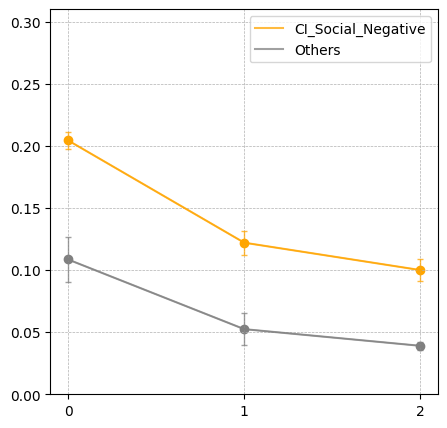

In [10]:
data_exp = convert_annotations_to_proportions(results_exp)

#lmer

lmer(data_exp, lmer_levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

ALL_DATA = {}
ALL_DATA[EXP[0]] = data_exp
plot(ALL_DATA, ax)

ax.set_xticks([0, 1, 2])
ax.set_ylim(0, 0.31)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend()

## Authors' Summaries / GPT-4 Evaluation

In [11]:
# define the chain
connections = [
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5

# define the api and task
llm_model_execute = None
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})

simulations = []
for study in [MUKI, TAKATORO]:
    if study == MUKI:
        doc = Document(str(study_data / MUKI_OUTPUT))
    else:
        doc = Document(str(study_data / TAKATORO_OUTPUT))
    
    summaries = []
    for para in doc.paragraphs:
        if para.text:
            summaries.append(para.text)

    task = TaskFactory.create(TaskType.MULTIPLEBIAS, llm_model_execute, llm_model_evaluate, study = study)
    for idx in range(n_simulations):
        all_nodes = setup_transmission_chain(connections, Node, task, idx)
        all_nodes[0][0].output = summaries[idx]
        all_nodes[1][0].inputs.append(summaries[idx])
        
        all_nodes[1][0].output = summaries[idx + 5]
        all_nodes[2][0].inputs.append(summaries[idx + 5])
        
        all_nodes[2][0].output = summaries[idx + 2*5]
        simulations.append(all_nodes)
        

In [12]:
async def run_evaluation(all_nodes):
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation])

await asyncio.gather(*[run_evaluation(all_nodes) for all_nodes in simulations])

in:  0 (1, 0)
in:  1 (2, 0)
in:  3 (1, 0)
in:  4 (2, 0)
in:  0 (1, 0)
in:  2 (2, 0)
in:  0 (2, 0)
in:  1 (1, 0)
in:  0 (2, 0)
in:  0 (0, 0)
in:  1 (2, 0)
in:  1 (0, 0)
in:  1 (0, 0)
in:  3 (1, 0)
in:  3 (0, 0)
in:  3 (0, 0)
in:  2 (1, 0)
in:  2 (0, 0)
in:  2 (1, 0)
in:  1 (1, 0)
in:  2 (2, 0)
in:  3 (2, 0)
in:  2 (0, 0)
in:  0 (0, 0)
in:  4 (0, 0)
in:  4 (1, 0)
in:  4 (0, 0)
in:  3 (2, 0)
in:  4 (2, 0)
in:  4 (1, 0)


[None, None, None, None, None, None, None, None, None, None]

In [13]:
all_sims = {
    MUKI : simulations[:n_simulations],
    TAKATORO: simulations[n_simulations:]
}

In [14]:
results = convert_summaries_to_annotations(all_sims)

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_6351/3068280005.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_6351/3068280005.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_6351/3068280005.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -32.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0485 -0.6733 -0.3241  0.3384  2.4393 

Random effects:
 Groups     Name        Variance Std.Dev.
 chain_id   (Intercept) 0.000000 0.00000 
 chain_step (Intercept) 0.002311 0.04807 
 Residual               0.014133 0.11888 
Number of obs: 30, groups:  chain_id, 5; chain_step, 3

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)   
(Intercept)                0.23659    0.04138  3.76441   5.717  0.00556 **
contentCI_Social_Negative  0.02910    0.04341 26.00000   0.670  0.50853   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cntntCI_S_N -0.525
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see he

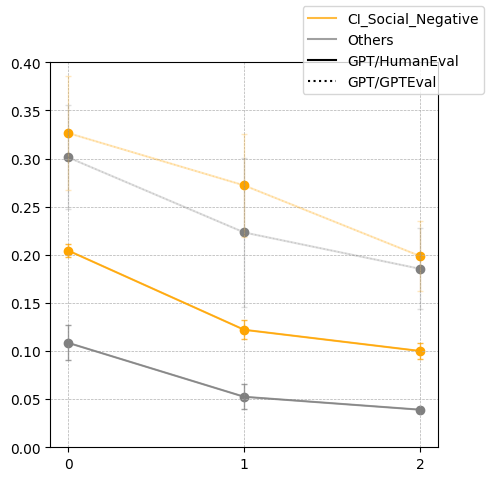

In [16]:
data = convert_annotations_to_proportions(results)

#lmer
lmer(data, lmer_levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

ALL_DATA = {}
ALL_DATA[EXP[0]] = data_exp
ALL_DATA[EXP[1]] = data
plot(ALL_DATA, ax)


ax.set_xticks([0, 1, 2])
ax.set_ylim(0, 0.4)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# legends
legends = []
extra_labels = []
for idx, key in enumerate(EXP):
    if key not in ALL_DATA:
        continue
    legends.append(plt.Line2D([0], [0], color='black', linestyle=LINESTYLES[idx], label=key))
    extra_labels.append(key)

handles, labels = ax.get_legend_handles_labels()

handles.extend(legends)
labels.extend(extra_labels)

# Create the legend with the combined handles and labels
fig.legend(handles, labels)

## New Summaries / GPT-4 Evaluation

In [25]:
# define the api and task
llm_model_execute = AzureOpenAIModel(AzureOpenAIModelType.GPT_3_5_TURBO, {})
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})

# define simulations asynchornously
async def run_simulation(connections, task, sim_idx):
    all_nodes = setup_transmission_chain(connections, Node, task, sim_idx)
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation ])
    return all_nodes

# define the chain
connections = [
    [[0]],
    [[0]],
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5
routines = []
for study in [MUKI, TAKATORO]:
    task = TaskFactory.create(TaskType.MULTIPLEBIAS, llm_model_execute, llm_model_evaluate, study = study)
    routines += [run_simulation(connections, task, idx) for idx in range(n_simulations)]

simulations = await asyncio.gather(*routines)

for i, all_nodes in enumerate(simulations):
    print(f"Simulation {i + 1} completed.")

sent output to  [Sim:4 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:1 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:2 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:2 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:3 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:1 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:0 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:4 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:2 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:4 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:0 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:3 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(

In [36]:
all_sims = {
    MUKI : simulations[:n_simulations],
    TAKATORO: simulations[n_simulations:]
}
results = convert_summaries_to_annotations(all_sims)
data2 = convert_annotations_to_proportions(results)

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_6351/119559959.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_6351/119559959.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_6351/119559959.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -26.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1784 -0.7071 -0.0678  0.5844  3.3126 

Random effects:
 Groups     Name        Variance Std.Dev.
 chain_step (Intercept) 0.000000 0.00000 
 chain_id   (Intercept) 0.003776 0.06145 
 Residual               0.026761 0.16359 
Number of obs: 48, groups:  chain_step, 5; chain_id, 5

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                0.32319    0.04327  8.21029   7.468 6.23e-05 ***
contentCI_Social_Negative  0.03615    0.04722 42.14251   0.766    0.448    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cntntCI_S_N -0.546
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see

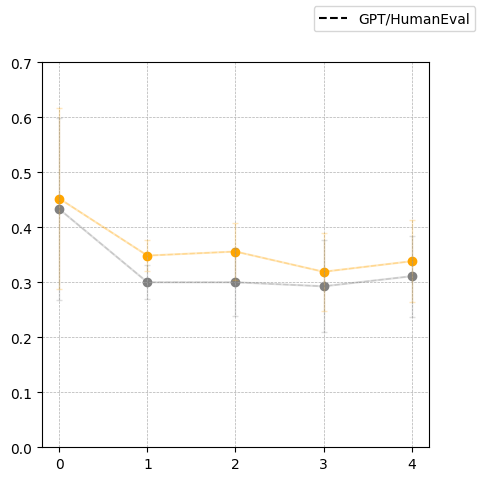

In [38]:
#lmer
lmer(data2, lmer_levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)


ALL_DATA = {}
# ALL_DATA[EXP[0]] = data_exp
# ALL_DATA[EXP[1]] = data
ALL_DATA[EXP[2]] = data2

plot(ALL_DATA, ax)

# minor adjustments
ax.set_xticks(range(5))
ax.set_ylim(0, 0.7)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# legends
# Add custom legend lines
legends = []
for idx, key in enumerate(EXP):
    if key not in ALL_DATA:
        continue
    legends.append(plt.Line2D([0], [0], color='black', linestyle=LINESTYLES[idx], label=key))

handles, labels = ax.get_legend_handles_labels()

handles.extend(legends)
labels.extend(EXP)

# Create the legend with the combined handles and labels
fig.legend(handles, labels)